In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


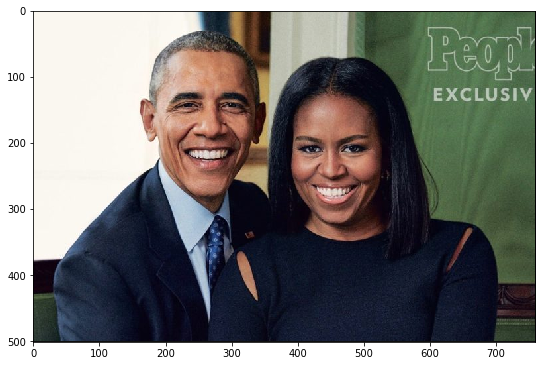

In [55]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.png')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

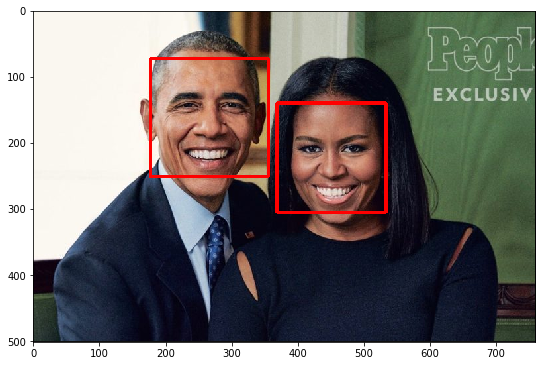

In [56]:

# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [60]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

checkpoint = torch.load(model_dir+model_name)
net.load_state_dict(checkpoint)

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

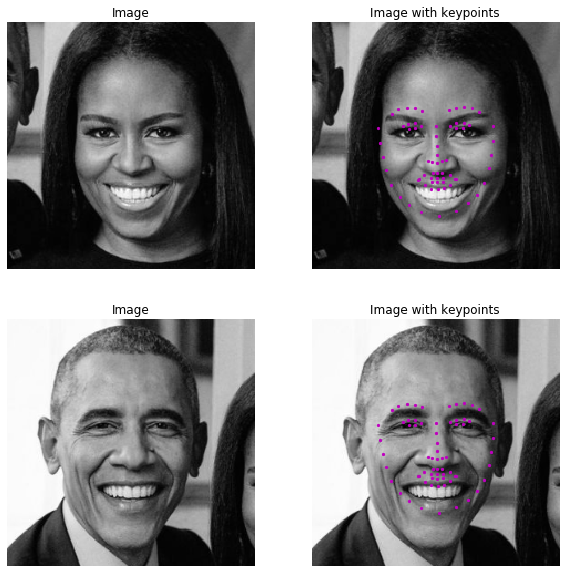

In [58]:
image_copy = np.copy(image)

results = []

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
    ## TODO: Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray_copy = np.copy(gray)
    gray_copy =  gray_copy/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    output_size = 224
    h, w = gray_copy.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(gray_copy, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    img_reshaped = img.reshape(1, 1, new_w, new_h)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    # convert images to FloatTensors
    input_img = torch.tensor(img_reshaped).type(torch.FloatTensor)

    # forward pass to get net output
    output_pts = net(input_img)
    output_pts = output_pts.view(68, -1)
    output_pts = output_pts.detach().numpy()
    # undo normalization of keypoints  
    output_pts = output_pts*50.0+100
    
    results.append((img, output_pts))
    

    ## TODO: Display each detected face and the corresponding keypoints        
    
fig, axs = plt.subplots(len(results), 2, figsize=(10, 10))

for i in range(len(results)):

    im, key_pts = results[i]

    axs[i, 0].imshow(im, cmap = 'gray')
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(im, cmap = 'gray')
    axs[i, 1].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    axs[i, 1].set_title('Image with keypoints')
    axs[i, 1].axis('off')

plt.show()